In [1]:
import warnings
import pandas as pd
from tqdm import tqdm

from helpers import classification as pf
from helpers import stats as bf
from helpers.file import save_file
from helpers.options import filtered_cols, selected_stats, strategy

from services import MySQLService

warnings.filterwarnings("ignore")

Setup Complete


In [20]:
league = "mls"
start_season = 2012
save_pipeline = False

random_state = 0

min_games_played = 10
min_games_played_at = 5

betting_starts_after_n_games = 0

min_odds = 2.5
bankroll = 900
strategy = "bankroll_pct"
default_value = 1
default_bankroll_pct = 0.05

plot_threshold = 0

In [3]:
matches, _ = bf.initialize_matches(league, start_season)
display(matches)

Generating teams ELOs...


100%|██████████| 5242/5242 [00:00<00:00, 8722.85it/s]

Successfully generated teams ELOs.


,season,league,date,week,home_team,home_xg,home_score,away_score,away_xg,away_team,home_odds,away_odds,draw_odds,result,home_elo,away_elo
0,2012,mls,2012-03-10,Regular Season,Colorado Rapids,NaN,2,0,NaN,Columbus Crew,2.00,3.65,3.20,H,1500.00,1500.00
1,2012,mls,2012-03-10,Regular Season,D.C. United,NaN,0,1,NaN,Sporting KC,2.45,2.74,3.18,A,1500.00,1500.00
2,2012,mls,2012-03-10,Regular Season,LA Galaxy,NaN,1,3,NaN,Real Salt Lake,1.77,4.43,3.37,A,1500.00,1500.00
3,2012,mls,2012-03-10,Regular Season,SJ Earthquakes,NaN,1,0,NaN,NE Revolution,1.78,4.38,3.42,H,1500.00,1500.00
4,2012,mls,2012-03-10,Regular Season,Vancouver W'caps,NaN,2,0,NaN,Montreal Impact,1.94,3.73,3.32,H,1500.00,1500.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5237,2024,mls,2024-10-27,Round One,Orlando City,1.6,2,0,0.8,Charlotte,NaN,NaN,NaN,H,1585.43,1542.86
5238,2024,mls,2024-10-28,Round One,FC Cincinnati,3.3,1,0,0.3,NYCFC,NaN,NaN,NaN,H,1570.16,1527.92
5239,2024,mls,2024-10-28,Round One,Seattle Sounders FC,1.0,0,0,0.5,Houston Dynamo,NaN,NaN,NaN,D,1610.47,1561.82
5240,2024,mls,2024-10-29,Round One,Columbus Crew,1.1,0,1,0.9,NY Red Bulls,NaN,NaN,NaN,A,1668.25,1502.29


In [4]:
data_model = []

for index, game in tqdm(matches.iterrows(), total=len(matches)):
    if pd.isnull(game["home_odds"]):
        continue

    home_stats_dict = bf.get_team_previous_games_stats(
        game["home_team"], game["season"], game["date"], "H", min_games_played, min_games_played_at, matches
    )
    if not home_stats_dict:
        continue

    away_stats_dict = bf.get_team_previous_games_stats(
        game["away_team"], game["season"], game["date"], "A", min_games_played, min_games_played_at, matches
    )
    if not away_stats_dict:
        continue

    game_info_keys = [
        "date",
        "season",
        "home_team",
        "away_team",
        "home_odds",
        "away_odds",
        "draw_odds",
        "result",
        "home_score",
        "away_score",
        "home_elo",
        "away_elo",
    ]
    game_info_dict = {key: game[key] for key in game_info_keys}

    data_model.append({**home_stats_dict, **away_stats_dict, **game_info_dict})

data_df = pd.DataFrame(data_model)

100%|██████████| 5242/5242 [01:15<00:00, 69.66it/s] 


In [5]:
display(data_df)

,home_points_pct,home_win_pct,home_draw_pct,home_loss_pct,home_points_pct_last_games,home_win_pct_last_games,home_draw_pct_last_games,home_loss_pct_last_games,home_home_win_pct,home_home_draw_pct,...,home_team,away_team,home_odds,away_odds,draw_odds,result,home_score,away_score,home_elo,away_elo
0,0.500000,0.416667,0.250000,0.333333,0.600000,0.500000,0.300000,0.200000,0.500000,0.333333,...,D.C. United,Colorado Rapids,2.05,3.43,3.25,H,2,0,1518.68,1508.29
1,0.500000,0.400000,0.300000,0.300000,0.500000,0.400000,0.300000,0.300000,0.400000,0.400000,...,Chicago Fire,FC Dallas,1.98,3.65,3.23,H,2,1,1504.15,1457.90
2,0.333333,0.272727,0.181818,0.545455,0.366667,0.300000,0.200000,0.500000,0.333333,0.166667,...,LA Galaxy,SJ Earthquakes,2.16,3.27,3.22,A,2,3,1469.21,1558.78
3,0.694444,0.666667,0.083333,0.250000,0.833333,0.800000,0.100000,0.100000,0.800000,0.200000,...,NY Red Bulls,Chivas USA,1.59,5.80,3.52,D,1,1,1554.99,1475.20
4,0.696970,0.636364,0.181818,0.181818,0.629630,0.555556,0.222222,0.222222,0.714286,0.000000,...,Seattle Sounders FC,Columbus Crew,1.50,6.90,3.60,A,0,2,1555.92,1484.58
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3286,0.474747,0.333333,0.424242,0.242424,0.333333,0.200000,0.400000,0.400000,0.437500,0.437500,...,NY Red Bulls,Columbus Crew,2.09,3.23,3.74,A,2,3,1508.12,1662.42
3287,0.525253,0.454545,0.212121,0.333333,0.733333,0.700000,0.100000,0.200000,0.437500,0.250000,...,Orlando City,Atlanta Utd,1.76,3.89,4.27,A,1,2,1598.36,1493.61
3288,0.373737,0.272727,0.303030,0.424242,0.533333,0.500000,0.100000,0.400000,0.250000,0.312500,...,Philadelphia Union,FC Cincinnati,1.95,3.37,3.99,A,1,2,1543.46,1560.65
3289,0.565657,0.454545,0.333333,0.212121,0.433333,0.300000,0.400000,0.300000,0.625000,0.187500,...,Real Salt Lake,Vancouver W'caps,1.67,4.33,4.35,H,2,1,1555.96,1494.21


In [6]:
from helpers.classification import simulate

last_season = matches.iloc[-1]["season"]

# Train and evaluate model
print("Training and evaluating models throughout the seasons...")
for season in tqdm(range(start_season + 1, last_season + 1)):
    matches, trained_models = pf.simulate(
        data_df,
        start_season,
        season,
        filtered_cols,
        betting_starts_after_n_games,
        strategy,
        verbose=1,
        random_state=0,
        preprocess=True,
        voting_classifier_models=["ada_boost", "knn", "logistic_regression"]
    )

Training and evaluating models throughout the seasons...


100%|██████████| 12/12 [01:16<00:00,  6.40s/it]


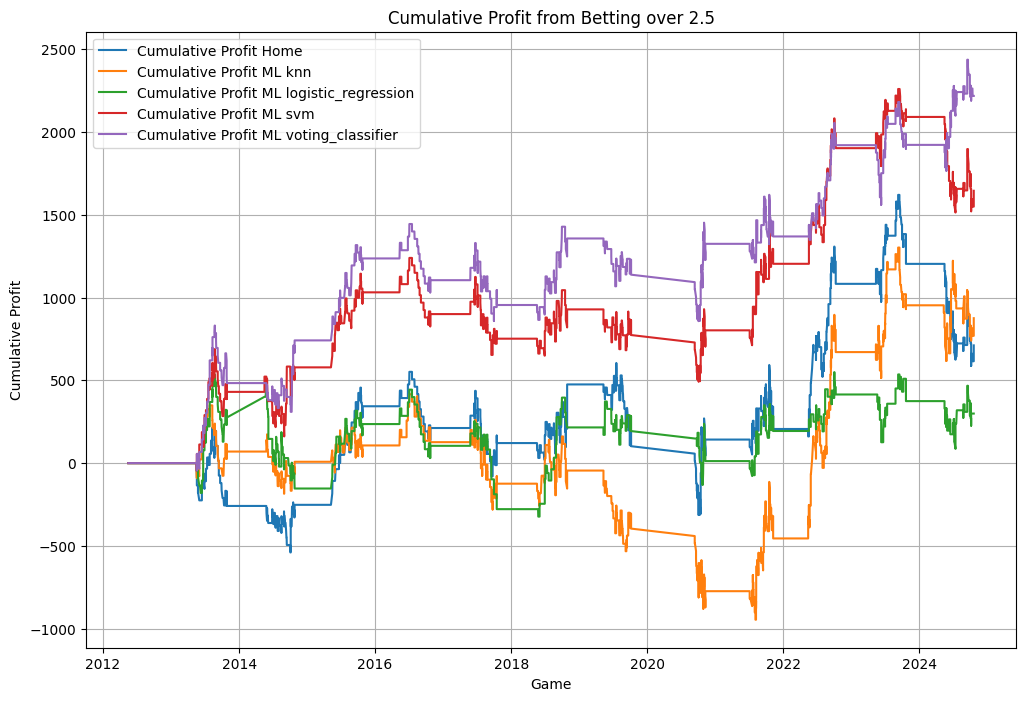

Home method (711.0/474): 1.5
ML method with naive_bayes          --> ( -574.2/1129): -0.5086
ML method with knn                  --> ( 875.25/514): 1.7028
ML method with logistic_regression  --> ( 299.25/340): 0.8801
ML method with svm                  --> (1644.75/429): 3.8339
ML method with random_forest_default --> ( -365.4/510): -0.7165
ML method with random_forest        --> ( -551.7/424): -1.3012
ML method with gradient_boosting    --> (  -49.5/640): -0.0773
ML method with ada_boost            --> (-379.35/760): -0.4991
ML method with mlp                  --> (-1889.1/478): -3.9521
ML method with voting_classifier    --> ( 2217.6/390): 5.6862

Profit for voting_classifier: $2217.6
Accuracy for voting_classifier: 0.52
Classification Report for voting_classifier:
              precision    recall  f1-score   support

           A       0.54      0.07      0.13       765
           D       0.41      0.01      0.02       752
           H       0.52      0.98      0.68      1563

    

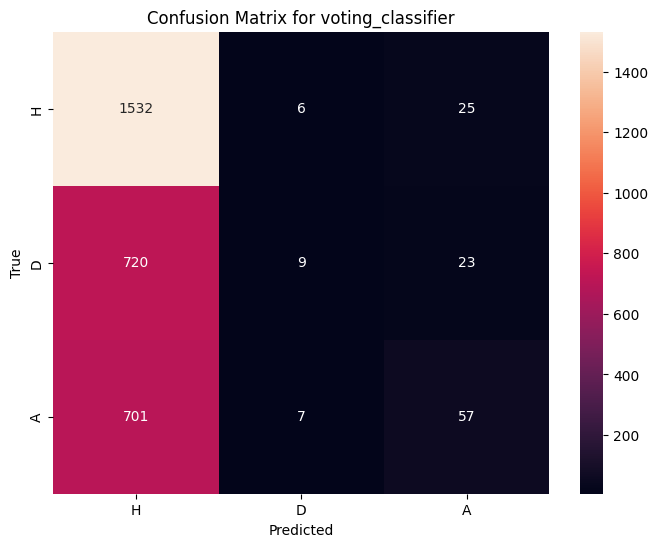

In [17]:
best_model_name = pf.get_simulation_results(matches, start_season, min_odds, plot_threshold, random_state, bankroll, strategy, default_value, default_bankroll_pct)

In [8]:
matches_filtered = matches[["date",  "season", "home_team", "away_team", "home_score", "away_score", "result", "home_odds", "draw_odds", "away_odds", f"PredictedRes_{best_model_name}", f'ProfitML_{best_model_name}', f'CumulativeProfitML_{best_model_name}']]
matches_filtered = matches_filtered[matches_filtered["season"] == 2024]
matches_filtered.tail(5)

# matches_filtered.to_csv("analysis_predictor.csv")

,date,season,home_team,away_team,home_score,away_score,result,home_odds,draw_odds,away_odds,PredictedRes_voting_classifier,ProfitML_voting_classifier,CumulativeProfitML_voting_classifier
3286,2024-10-19,2024,NY Red Bulls,Columbus Crew,2,3,A,2.09,3.74,3.23,H,0.0,2217.6
3287,2024-10-19,2024,Orlando City,Atlanta Utd,1,2,A,1.76,4.27,3.89,H,0.0,2217.6
3288,2024-10-19,2024,Philadelphia Union,FC Cincinnati,1,2,A,1.95,3.99,3.37,H,0.0,2217.6
3289,2024-10-19,2024,Real Salt Lake,Vancouver W'caps,2,1,H,1.67,4.35,4.33,H,0.0,2217.6
3290,2024-10-19,2024,Seattle Sounders FC,Portland Timbers,1,1,D,1.59,4.47,4.88,H,0.0,2217.6


In [19]:
my_pipeline = trained_models[best_model_name]["pipeline"]
my_pipeline

data = {
    "pipeline": my_pipeline,
    "best_model_name": best_model_name,
    "min_games_played": min_games_played,
    "min_games_played_at": min_games_played_at,
    "min_odds": min_odds,
    "filtered_cols": filtered_cols,
    "strategy": strategy,
    "default_value": default_value,
    "default_bankroll_pct": default_bankroll_pct
}

# Save the pipeline
if save_pipeline:
    path = f"../dist/betting"
    
    save_file(path, data, league)